In [147]:
# adaptive gradient methods

In [335]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import pandas as pd
import torch.nn.functional as F
import torch.optim

In [336]:
dataset = pd.read_csv("iris.csv").values

In [337]:
def preprocess(data):
    X = dataset[:,0:4].astype("float32")
    encoder = lambda y: 0 if y=="Setosa" else(1 if y == "Versicolor" else 2) 
    y = [encoder(i) for i in dataset[:,-1]]
    return X,y

In [338]:
X,y = preprocess(dataset)


In [339]:

X = torch.tensor(X)
y = torch.tensor(y)

In [340]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        
        super(NeuralNetwork,self).__init__()
        self.l1 = nn.Linear(4,4)
        self.l2 = nn.Linear(4,3)
        self.softmax = nn.Softmax(dim=0)
    
    def forward(self,x):
        
        out = self.l1(x)
        out = self.l2(out)
        out = self.softmax(out)
        
        return out

In [341]:
model = NeuralNetwork()

In [354]:
# mad grad implementation from https://github.com/facebookresearch/madgrad/tree/master/madgrad

class madgrad(torch.optim.Optimizer):
    
     def __init__(self,params,lr = 1e-2, momentum= 0.9, weight_decay=0, eps= 1e-6):
        
        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)
    
     def step(self):
        
        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()
        
        for group in self.param_groups:
        
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]
            
            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)
            
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]
                 
                # Apply weight decay
                if decay != 0:
                    grad.add_(p.data, alpha=decay)

            
                if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                else:
                        x0 = state["x0"]

                    # Accumulate second moments
                grad_sum_sq.addcmul_(grad, grad, value=lamb)
                rms = grad_sum_sq.pow(1 / 3).add_(eps)

                # Update s
                s.data.add_(grad, alpha=lamb)

                # Step
                if momentum == 0:
                    p.data.copy_(x0.addcdiv(s, rms, value=-1))
                else:
                    z = x0.addcdiv(s, rms, value=-1)

                    # p is a moving average of z
                    p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss



In [350]:
creatrion = nn.CrossEntropyLoss()
optimizer = madgrad(model.parameters())

In [351]:
# traning

losses = []


for i in range(1000):
    

    output = model(X)

    loss = creatrion(output, y)
    
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    
    

    if i%100 == 0:
        losses.append(loss.item())
        print(loss.item())

1.098893165588379
1.0913211107254028
1.0894650220870972
1.0887435674667358
1.0877349376678467
1.086952805519104
1.086586833000183
1.0864274501800537
1.0863518714904785
1.0863113403320312


In [352]:
%matplotlib inline

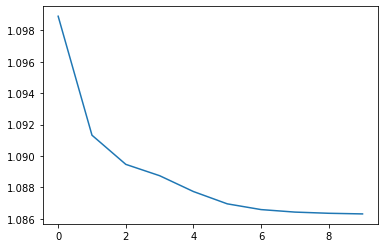

In [353]:
plt.plot(losses)